# SpEAR-speech-database

In this notebook, we will download the data required and then extract the MFCC features from this dataset, and store it as a pytorch tensor file

First, download the data files, extract the data and save the files to the directory

In [6]:
import sys
import time
import urllib
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import scipy
import librosa.display
from IPython.display import Audio

import torch

import matplotlib.pyplot as plt
import librosa

DATA_DIR = "../data/raw/"
FILENAME = "SpEAR"

In [47]:
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

f = urllib.request.urlretrieve("https://github.com/dingzeyuli/SpEAR-speech-database/archive/master.zip", DATA_DIR + FILENAME + ".zip", reporthook)



with zipfile.ZipFile(f[0],"r") as zip_ref:
    zip_ref.extractall(DATA_DIR)
    zip_ref.close()
    print("... data unzipped")
    

os.remove(f[0])
print("zip file deleted")

...-1606451200%, 15 MB, 1400 KB/s, 11 seconds passed... data unzipped
zip file deleted


Then, extract the MFCC features from the data. 
See https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html

Lets hear that audio!

In [20]:
Audio(audio_file_path)

Add noise to the audio:

https://www.kaggle.com/huseinzol05/sound-augmentation-librosa

In [8]:
sample_rate, samples = scipy.io.wavfile.read(audio_file_path)
y_noise = samples.copy()
# you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
noise_amp = 0.15*np.random.uniform()*np.amax(y_noise)
y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
Audio(y_noise, rate=sample_rate)

Upsampling

In [31]:
y_22k = librosa.resample(samples.astype(np.float32), sample_rate, 22050)
Audio(y_22k, rate=22050)

### Working with MFCC

Extract the MFCC features

In [8]:
mfcc_features = mfcc(y_noise)

Saving the Features

In [22]:
PROCESSED = "../data/processed{}{}/".format(SpEAR_NAME, TIMIT)

mfcc_pt = torch.from_numpy(mfcc_features)

try:  
    os.makedirs(PROCESSED)
except OSError:  
    print ("Creation of the directory %s failed" % PROCESSED)
else:  
    print ("Successfully created the directory %s " % PROCESSED)

torch.save(mfcc_pt, "{}{}".format(PROCESSED, audio_file.replace(".wav", ".pt")))

print("features saved")

Creation of the directory ../data/processed/SpEAR-speech-database-master/data/TIMIT/ failed
features saved


### Working with Mel-Spectograms

First we will extract the mel-spectrogram from the clean signal

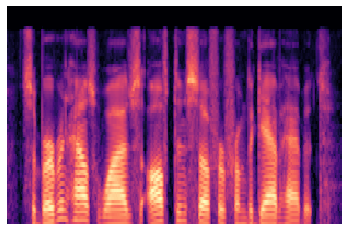

In [32]:
S = librosa.feature.melspectrogram(y=y_22k.astype(np.float32),
                                   sr=sample_rate,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.show()

Now the noisy signal

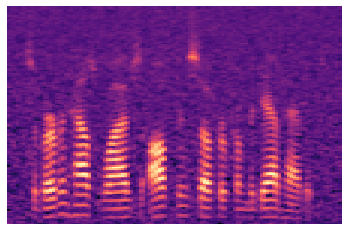

In [28]:
S2 = librosa.feature.melspectrogram(y=y_noise.astype(float), sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S2, ref=np.max))
plt.show()

Now, lets save the spectrogram as a numpy file.

In [35]:
PROCESSED = "../data/processed{}{}/".format(SpEAR_NAME, TIMIT)

np.save("{}{}".format(PROCESSED, audio_file.replace(".wav", ".npy")), S.T)

Script to generate audio from pre-trained model

```
python synthesis.py --preset=20180510_mixture_lj_checkpoint_step000320000_ema.json \
  --conditional=../fix-it-in-post.net/data/processed/SpEAR-speech-database-master/data/TIMIT/housewives_16.npy \
  20180510_mixture_lj_checkpoint_step000320000_ema.pth \
  generated
```

### Working with STFT

In [11]:
S3 = librosa.stft(samples.astype(np.float32), n_fft = 1024)

